<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [706]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [707]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [708]:
train=pd.read_csv('drive/MyDrive/ML_course/train.csv')
train.drop(['Surname', 'CustomerId'], axis=1, inplace=True)

In [709]:
train.head()

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [710]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CreditScore      15000 non-null  float64
 2   Geography        15000 non-null  object 
 3   Gender           15000 non-null  object 
 4   Age              15000 non-null  float64
 5   Tenure           15000 non-null  float64
 6   Balance          15000 non-null  float64
 7   NumOfProducts    15000 non-null  float64
 8   HasCrCard        15000 non-null  float64
 9   IsActiveMember   15000 non-null  float64
 10  EstimatedSalary  15000 non-null  float64
 11  Exited           15000 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.4+ MB


In [711]:
X=train.iloc[:,:-1]
y=train.Exited

In [712]:
train.Exited.value_counts(normalize=True)

,proportion
Exited,
0.0,0.796533
1.0,0.203467


In [713]:
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [714]:
input_cols=train.iloc[:, :-1].columns
target_col=train.iloc[:,-1].name
train_inputs=X_train
val_inputs=X_val
train_targets=y_train
val_targets=y_val

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [715]:
numeric_cols=train_inputs.select_dtypes(exclude='object').columns.tolist()
categorical_cols=train_inputs.select_dtypes(include='object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [716]:
for i in categorical_cols:
  print(train[i].value_counts())

Geography
France     9032
Spain      3303
Germany    2665
Name: count, dtype: int64
Gender
Male      8529
Female    6471
Name: count, dtype: int64


In [717]:
encoder=OneHotEncoder()
encoder.fit(train_inputs[categorical_cols])
geo_code_train=encoder.transform(train_inputs[categorical_cols]).toarray()
geo_code_val=encoder.transform(val_inputs[categorical_cols]).toarray()
categories=np.concatenate((encoder.categories_[0],encoder.categories_[1]))
train_inputs[categories]=geo_code_train
val_inputs[categories]=geo_code_val
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [718]:
from matplotlib import pyplot as plt
import seaborn as sns

In [719]:
scaler=StandardScaler()
scaler.fit(train_inputs[numeric_cols])
train_inputs[numeric_cols]=scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols]=scaler.transform(val_inputs[numeric_cols])

In [720]:
cols=np.concatenate((numeric_cols, categories))
train_inputs=train_inputs[cols]
val_inputs=val_inputs[cols]

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [721]:
train_inputs.to_parquet('drive/MyDrive/ML_course/train_inputs')
val_inputs.to_parquet('drive/MyDrive/ML_course/val_inputs')
train_targets.to_frame().to_parquet('drive/MyDrive/ML_course/train_targets')
val_targets.to_frame().to_parquet('drive/MyDrive/ML_course/val_targets')

In [722]:
!ls drive/MyDrive/ML_course

application_data.csv.zip	columns_description.gsheet    submission_log_reg.csv  train_targets
application_data_processed.zip	medical-charges.csv	      test.csv		      val_inputs
cars.csv			previous_application.csv.zip  train.csv		      val_targets
columns_description.csv		sample_submission.csv	      train_inputs


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [723]:
model=LogisticRegression()
model.fit(train_inputs, y_train)
y_pred_train=model.predict(train_inputs)
y_pred_val=model.predict(val_inputs)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [724]:
confusion_matrix(y_train, y_pred_train)

array([[8582,  379],
       [1030, 1259]])

In [725]:
confusion_matrix(y_val, y_pred_val)

array([[2836,  151],
       [ 336,  427]])

In [726]:
y_pred_proba=model.predict_proba(val_inputs)[:,1]

In [727]:
y_proba_train=model.predict_proba(train_inputs)[:,1]

In [728]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc=auc(fpr, tpr)

In [729]:
roc_auc

0.8797638170824116

In [730]:
fpr, tpr, thresholds = roc_curve(y_train, y_proba_train)
roc_auc=auc(fpr, tpr)

In [731]:
roc_auc

0.8827599077581417

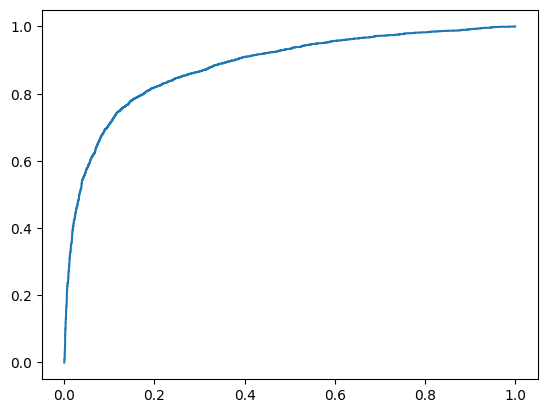

In [732]:
plt.plot(fpr, tpr)

In [733]:
f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val),

(0.6412019353195824, 0.6368381804623415)

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [734]:
val_targets.value_counts()

,count
Exited,
0.0,2987
1.0,763


In [735]:
val_targets.value_counts()
acc_val=2987/(2987+763)

In [736]:
acc_val

0.7965333333333333

In [737]:
confusion_matrix(y_val, y_pred_val)

array([[2836,  151],
       [ 336,  427]])

In [738]:
confusion_matrix(y_train, y_pred_train)

array([[8582,  379],
       [1030, 1259]])

In [739]:
model_acc_tr=8603/(8603+358)

In [740]:
model_acc_tr

0.9600491016627608

In [741]:
model_acc=2847/(2847+140)

In [742]:
model_acc

0.9531302310010044

Передбачення моделі набагато точніші в порівнянні з моделлю, що присвоює всі дані до мажоритарного класу 95% проти 79%.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [743]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[categories] = encoder.transform(input_df[categorical_cols]).toarray()
    X_input = input_df[cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [744]:
test_raw_df=pd.read_csv('drive/MyDrive/ML_course/test.csv')

In [745]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

array([0.07158194, 0.03400357, 0.15666596, ..., 0.01809158, 0.16138252,
       0.0946081 ])

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [746]:
sample_submission=pd.read_csv('drive/MyDrive/ML_course/sample_submission.csv')

In [747]:
sample_submission['Exited']=predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [751]:
sample_submission.set_index('id')

,Exited
id,
15000,0.057039
15001,0.001124
15002,0.015047
15003,0.014611
15004,0.001099
...,...
24995,0.000990
24996,0.001011
24997,0.011660


In [753]:
sample_submission.to_csv('drive/MyDrive/ML_course/submission_log_reg.csv', index=False)